In [11]:
from importlib import reload
import time
import joblib
from pylab import *
from tqdm import tqdm


import sys
sys.path.append("..")

from helper_basic import *
import helper_basic as hp
import helper_finetime as hpt
import helper_visa as vs
reload(vs)
import config


# Analysis 0: Calibration

In [30]:
path = config.scope
filename = config.scope+"pulse_shape/preamp_v5b_A_sipm_calibration.joblib"

data_save=joblib.load(filename)
time_series = data_save["metadata"]["time_series"]*1e9

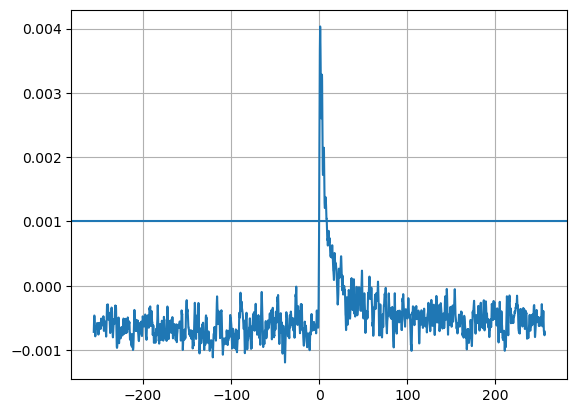

In [31]:
# Have a look at one pulse, and choose a trigger threshold
trigger_threshold_edge = 0.001

plot(time_series, data_save[1][3])
axhline(trigger_threshold_edge)

# xlim(-2,8)
grid()

In [32]:
traces = data_save[1]
pre_trig = len(traces[0])//2- 200

pulse_info = hp.get_pulses_info(traces, pre_trig=pre_trig, threshold_in_sigma=5, gaussian_filter_sigma=3)
# [trace_means,trace_max,trace_std,trace_slope,trace_skew, trace_pileups, trace_trigger_point, trace_amp]

Trigger threshold 0.0007672548235859722


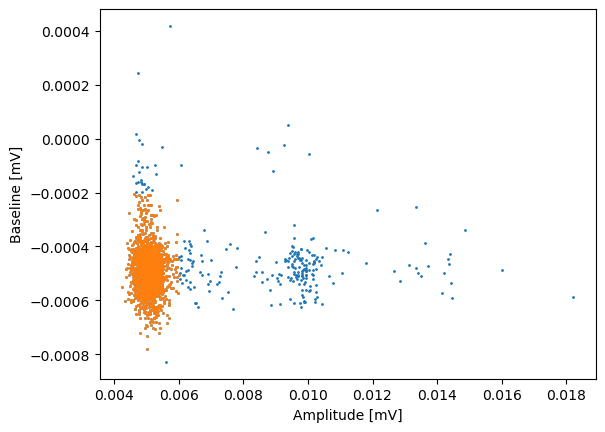

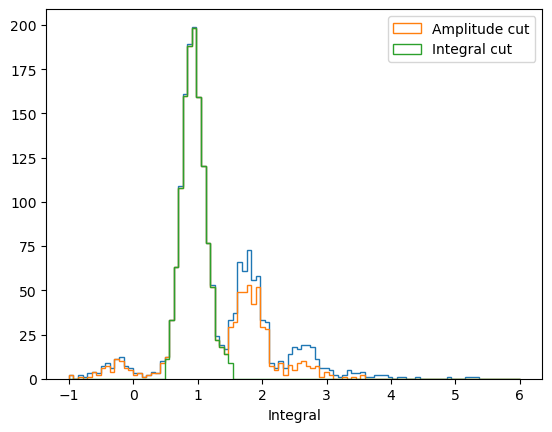

In [33]:
trace_amp = pulse_info[:,-1]
trace_baseline = pulse_info[:,0]

mask = (trace_baseline>-0.0008)&(trace_amp<0.006)&(trace_baseline<-0.0002)
scatter(trace_amp, trace_baseline, s=1)
scatter(trace_amp[mask], trace_baseline[mask], s=1)
# hist(pulse_info[:,ind_amp], bins=100, range=(0,0.02));
xlabel("Amplitude [mV]")
ylabel("Baseline [mV]")
show()

trace_integral = np.array([np.sum(trace - np.mean(trace[:int(len(trace)/2.1)])) for trace in traces])
mask_integral = (trace_integral>0.5)&(trace_integral<1.5)

bins=np.linspace(-1,6, 100)
hist(trace_integral, bins=bins, histtype="step");
hist(trace_integral[mask], bins=bins, histtype="step", label="Amplitude cut");
hist(trace_integral[mask&mask_integral], bins=bins, histtype="step", label="Integral cut");
xlabel("Integral")
legend()
show()


mask = mask&mask_integral

0.5323417198237861,3.240570346238456,20.167974020972608,0.026719957756465323,0.01265727420465918,-0.33453595670500963,0.00437908170079045


/home/mathusla/tofpet/Mu-Hardware/SystemCharacterization/../helper_basic.py:62: RuntimeWarning: divide by zero encountered in divide
  pulse/=max(pulse)
/home/mathusla/tofpet/Mu-Hardware/SystemCharacterization/../helper_basic.py:62: RuntimeWarning: invalid value encountered in divide
  pulse/=max(pulse)


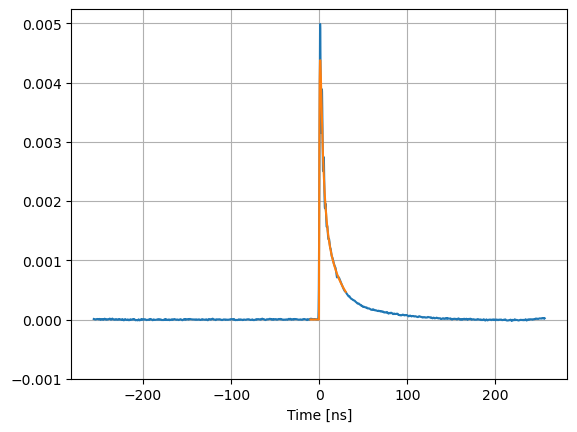

In [41]:
trace_original =np.array(data_save[1])[mask]
trace_original_avg = np.mean(trace_original, axis=0)#*np.mean(trace_amps)
trace_original_avg-=np.mean(trace_original_avg[time_series<-10])
# trace_original_avg/=max(trace_original_avg)



plot(time_series, trace_original_avg)

x=time_series
y=trace_original_avg
popt, pcov, info, f = hp.fit_curve(hp.Pulse2,x,y, fit_range=[-10,30],
                                    p0=[0.5,2,30,np.max(y),np.max(y),x[np.argmax(y)],np.max(y)], maxfev=10000, makeplot=True)

# yscale("log")
# xlim(-2,30)
ylim(-0.001,)
grid(which="both")
xlabel("Time [ns]")
print(*popt, sep=",")

In [42]:
pulse_save = {"time_series_ns":time_series,
              "averaged_pulse_1pe_volt":trace_original_avg}
joblib.dump(pulse_save, os.path.splitext(filename)[0]+"_averaged.joblib")

import pickle

with open(os.path.splitext(filename)[0]+"_averaged.pkl", "wb") as f:
    pickle.dump(pulse_save, f)

Amplitude 0.0049916413 Integral 0.93877184
9.057112e-08
0.9122643
Amplitude 0.005123471 Integral 0.95458937
0.0032942467
0.93669623


Text(0.5, 0, 'Time [ns]')

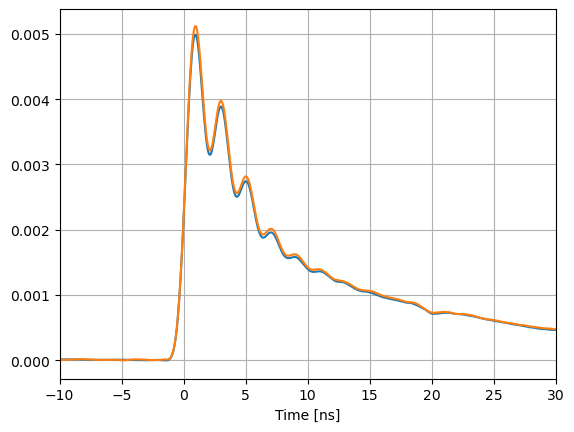

In [44]:
files = ["/mnt/sda2//scope_data/pulse_shape/preamp_v5b_A_sipm_calibration_averaged.joblib",
         "/mnt/sda2//scope_data/pulse_shape/preamp_v5b_B_sipm_calibration_averaged.joblib",]


labels=["Original", "Additional capacitor 60 pF"]

for i in range(len(files)):
    data=joblib.load(files[i])
    average_pulse = data["averaged_pulse_1pe_volt"]
    print("Amplitude", max(average_pulse), "Integral", sum(average_pulse[4000:]))
    # average_pulse/=max(average_pulse)
    # print(sum(average_pulse[(data["time_series_ns"]<-10)]))
    print(sum(average_pulse[(data["time_series_ns"]>-10)&(data["time_series_ns"]<100)]))
    plot(data["time_series_ns"], average_pulse)

xlim(-10,30)
grid(which="both")
xlabel("Time [ns]")
# savefig(config.scope+"/plots/preamp_v5_30pF_b_newSiPM_averaged_pulse.jpg")